<a href="https://colab.research.google.com/github/SullyK/CNN_backup/blob/main/finally_there.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO**:
- I need to do the annnotations - https://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html
- Test the annotation on a smaller dataset to see how accurate the results are.
- Maybe use the larger dataset
- Start bg research and write up tomorrow 

In [1]:
import os
import csv
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
import numpy as np
from numpy import zeros
from numpy import asarray




In [2]:
!nvidia-smi

Thu Apr 14 00:29:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# import shutil

# shutil.rmtree('/content/Mask_RCNN')


In [4]:

# !git clone https://github.com/matterport/Mask_RCNN
# !git clone https://github.com/akTwelve/Mask_RCNN
!git clone https://github.com/SullyK/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 125.28 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [5]:
os.chdir("/content/Mask_RCNN")

In [6]:
pip install -r requirements.txt


     |████████████████████████████████| 462 kB 9.0 MB/s 
     |████████████████████████████████| 297 kB 58.8 MB/s 
     |████████████████████████████████| 154 kB 77.1 MB/s 


In [7]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y




Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [8]:
!pip install tensorflow==2.4.0
!pip install keras
!pip install h5py==2.10.0
!pip install Pillow



     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 2.9 MB 64.2 MB/s 
     |████████████████████████████████| 14.8 MB 54.3 MB/s 
     |████████████████████████████████| 3.8 MB 51.9 MB/s 
     |████████████████████████████████| 462 kB 61.5 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 132 kB 73.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68698 sha256=151534c507f774fe54017e7c56378d6e943c2389e43fe21d67228571f8d1b037
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:


     |████████████████████████████████| 1.4 MB 7.3 MB/s 


In [9]:
os.getcwd()

'/content/Mask_RCNN'

In [10]:
# Import Mask RCNN
ROOT_DIR = "/content/"
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


In [13]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


... done downloading pretrained model!


In [88]:
class sullyConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "MASKRCNN_CONFIG"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256 #Might have to put this back in
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 250

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 40
    
config = sullyConfig()
# config.BATCH_SIZE = 16
config.display()




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [68]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  

In [69]:
!pip3 install scikit-image==0.16.2
import skimage.io


MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant048_label
PRINTING F  80fccc5dc6934b29a40b9f3c701733f2.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant048_label/80fccc5dc6934b29a40b9f3c701733f2.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(347, 329)
PRINTING F  168b54ea7aaf414eb91278872a6580d5.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant048_label/168b54ea7aaf414eb91278872a6580d5.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:

In [70]:

# original class

# class PlantDataset(utils.Dataset):
#   def load_dataset(self,dataset_dir,is_train=True):
#     self.add_class("dataset", 1, "leaf")


#     images_dir = dataset_dir

#     for filename in os.listdir(images_dir):
#       image_id = filename[:-4] #remove the .png or w/e

#       if "rgb" not in image_id: #check to see if it's the image(always has rgb)
#         continue

#       number = int(image_id[13:16])

#       if is_train and number >= 100:
#           continue

#       if not is_train and number < 100:
#           continue

      
      
#       img_path = images_dir + "/" + filename
#       ann_path = images_dir + "/" + image_id[:17] + 'bbox.csv'

#       self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


#   def extract_boxes(self,filename):
#     file = open(filename)
#     with open(filename, 'r') as csvfile:
#       reader = csv.reader(csvfile)
#       boxes = []
#       for row in reader:
#         row = [int(i) for i in row]
#         x_max = max(row[1],row[3],row[5],row[7])
#         x_min = min(row[1],row[3],row[5],row[7])
#         assert x_max >= x_min #xmax is always equal to or greater than x_min
#         y_max = max(row[2],row[4],row[6],row[8])
#         y_min = min(row[2],row[4],row[6],row[8])
#         assert y_max >= y_min #ymax is always equal to or greater than y_min

#         coors = [x_min,y_min,x_max,y_max]
#         boxes.append(coors)
#         image_name = filename[:-8] + "rgb.png"
#         image = PIL.Image.open(image_name)
#         width, height = image.size
#         # print("width" + width)

#         # print(boxes)

#       return boxes,width,height

#   def load_mask(self,image_id):
#     info = self.image_info[image_id]
#     path = info['annotation']
#     boxes, w,h = self.extract_boxes(path)
#     masks = zeros([h, w, len(boxes)], dtype='uint8')
#     class_ids = list()
#     for i in range(len(boxes)):
#       box = boxes[i]
#       row_s, row_e = int(box[1]), int(box[3])
#       col_s, col_e = int(box[0]), int(box[2])
#       masks[row_s:row_e, col_s:col_e, i] = 1
#       class_ids.append(self.class_names.index('leaf'))
#     return masks, asarray(class_ids, dtype='int32')

#   def image_reference(self, image_id):
#       info = self.image_info[image_id]
#       print(info)
#       return info['path']

#   #--------

#   # img_name = "ara2012_plant007_rgb"
#   # img = skimage.io.imread("/content/drive/MyDrive/Plant/Ara2012/ara2012_plant007_rgb.png")


#   # fig, ax = matplotlib.pyplot.subplots()
#   # ax.imshow(img)

#   # string_boxes = extract_boxes("/content/drive/MyDrive/Plant/Ara2012/ara2012_plant007_bbox.csv")
#   # print(string_boxes[0][0])
  


#   #debug bboxes
#   # x = []
#   # for i in string_boxes[0][4]:
#   #   print(i)
#   #   x.append(int(i))
  
#   # # rect = matplotlib.patches.Rectangle(((x[0]),x[1]),
#   # #                                     x[2] - x[0],
#   # #                                     x[3]-x[1],
#   # #                                     linewidth=1, 
#   # #                                     edgecolor='r', 
#   # #                                     facecolor='none')



#   # ax.add_patch(rect)

#   # matplotlib.pyplot.show()









In [71]:

# #Using the massive dataset:


# class PlantDataset(utils.Dataset):
#   def load_dataset(self,dataset_dir,is_train=True):
#     self.add_class("dataset", 1, "leaf")


#     images_dir = dataset_dir

#     for filename in os.listdir(images_dir):
#       image_id = filename[:-4] #remove the .png or w/e

#       # if "rgb" not in image_id: #check to see if it's the image(always has rgb)
#       #   continue
#       print(image_id)
#       number = image_id[5:9]
#       number = int(number)
#       print(number)
#       if is_train and number >= 1000:
#           continue

#       if not is_train and number < 1000:
#           continue

#       print(f"filename {filename}")
      
#       string_csv = '.csv'
#       img_path = images_dir + "/" + image_id + '.jpg'
#       print(img_path)
#       ann_path = images_dir + "/" + image_id + '.csv'
#       # print(ann_path)

#       self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


#   def extract_boxes(filename):
#     file = open(filename)
#     with open(filename, 'r') as csvfile:
#       reader = csv.reader(csvfile)
#       boxes = []
#       for row in reader:
#         row = row[1:5]
#         row = [int(i) for i in row]

#         coors = [row[0],row[1],row[2],row[3]]
#         boxes.append(coors)
#         image_name = filename.replace('csv','jpg')
#         print(boxes)

#         image = PIL.Image.open(image_name)
#         width, height = image.size
#         # print(width)
#         # print(height)


#       return boxes,width,height

#   def load_mask(self,image_id):
#     info = self.image_info[image_id]
#     path = info['annotation']
#     boxes, w,h = self.extract_boxes(path)
#     masks = zeros([h, w, len(boxes)], dtype='uint8')
#     class_ids = list()
#     for i in range(len(boxes)):
#       box = boxes[i]
#       row_s, row_e = int(box[1]), int(box[3])
#       col_s, col_e = int(box[0]), int(box[2])
#       masks[row_s:row_e, col_s:col_e, i] = 1
#       class_ids.append(self.class_names.index('leaf'))
#     return masks, asarray(class_ids, dtype='int32')

#   def image_reference(self, image_id):
#       info = self.image_info[image_id]
#       print(info)
#       return info['path']

#   #--------


#   # img_name = "ara2012_plant007_rgb"
#   img = skimage.io.imread("/content/drive/MyDrive/plant_set/LEAF_0762.jpg")


#   fig, ax = matplotlib.pyplot.subplots()
#   ax.imshow(img)

#   string_boxes = extract_boxes("/content/drive/MyDrive/plant_set/LEAF_0762.csv")
#   print(string_boxes[0][0])

#   # # debug bboxes
#   x = []
#   for i in string_boxes[0][0]:
#     print(i)
#     x.append(int(i))
  
#   rect = matplotlib.patches.Rectangle(((x[0]),x[1]),
#                                       x[2],
#                                       x[3],
#                                       linewidth=1, 
#                                       edgecolor='r', 
#                                       facecolor='none')



#   ax.add_patch(rect)

#   matplotlib.pyplot.show()









In [72]:

from PIL import Image, ImageDraw
import skimage.draw
import cv2


class PlantDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,is_train=True):
    self.add_class("dataset", 1, "leaf")
    images_dir = dataset_dir

    for filename in os.listdir(images_dir):
      image_id = filename[:-4] #remove the .png or w/e

      if "rgb" not in image_id: #check to see if it's the image(always has rgb)
        continue

      number = int(image_id[13:16])

      if is_train and number >= 100:
          continue

      if not is_train and number < 100:
          continue

      
      
      img_path = images_dir + "/" + filename
      # ann_path = images_dir + "/" + image_id[:17] + '.png'
      ann_path = images_dir + "/" + "a2012/" +  image_id[:17] + 'label'
      print(ann_path)

      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)


  def extract_boxes(self,filename):
    file = open(filename)
    with open(filename, 'r') as csvfile:
      reader = csv.reader(csvfile)
      boxes = []
      for row in reader:
        row = [int(i) for i in row]
        x_max = max(row[1],row[3],row[5],row[7])
        x_min = min(row[1],row[3],row[5],row[7])
        assert x_max >= x_min #xmax is always equal to or greater than x_min
        y_max = max(row[2],row[4],row[6],row[8])
        y_min = min(row[2],row[4],row[6],row[8])
        assert y_max >= y_min #ymax is always equal to or greater than y_min

        coors = [x_min,y_min,x_max,y_max]
        boxes.append(coors)
        image_name = filename[:-8] + "rgb.png"
        image = PIL.Image.open(image_name)
        width, height = image.size
        # print("width" + width)

        # print(boxes)

      return boxes,width,height

  # def load_mask(self,image_id):
  #   info = self.image_info[image_id]
  #   print("yayyyyyy info :", info)
  #   path = info['annotation']
  #   print("oooooo path :", path)

  #   boxes, w,h = self.extract_boxes(path)
  #   masks = zeros([h, w, len(boxes)], dtype='uint8')
  #   class_ids = list()
  #   for i in range(len(boxes)):
  #     box = boxes[i]
  #     row_s, row_e = int(box[1]), int(box[3])
  #     col_s, col_e = int(box[0]), int(box[2])
  #     masks[row_s:row_e, col_s:col_e, i] = 1
  #     class_ids.append(self.class_names.index('leaf'))
  #   return masks, asarray(class_ids, dtype='int32')



  def load_mask(self, image_id):
    """Generate instance masks for an image.
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """

# Read mask files from .png image
    info = self.image_info[image_id]
    # Get mask directory from image path
    mask_dir = info['annotation']
    print("MASK DIR " , mask_dir)
    # print("PRINTING Files " , f)

    mask = []

    for root, dirs, files in os.walk(mask_dir):
        for f in files:
            # print(os.path.join(root, f))
            print("PRINTING F ", f)
            # print("WE NVER GET HERE???!?!?!?")
            if f.endswith(".png"):              
                print("location: ", mask_dir + '/'  + f )  
                m = skimage.io.imread(mask_dir + '/'  + f).astype(np.bool)
                if m.all() == True:
                  continue
                print("2 seee@@@@ : ", m)
                print("printing shape:")
                print(m.shape)
                mask.append(m)
    mask = np.stack(mask, axis=-1)
    return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    # mask = []
    # for root, dirs, files in os.walk(mask_dir):
    #     for f in files:
    #       print(mask_dir + '/'  + f)
    #       m = skimage.io.imread(mask_dir + '/'  + f,plugin='pil').astype(np.bool)
    #       # print(m)
    #       mask.append(m)

    # mask = np.stack(mask, axis=-1)
    # return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    # print("new mask: ", mask)
    # return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    # mask = []
    # for root, dirs, files in os.walk(mask_dir):
    #     for f in files:
    #       m = skimage.io.imread(mask_dir + '/'  + f).astype(np.bool)
    #       mask.append(m)
    #       mask = np.stack(mask, axis=-1)

    # mask = np.stack(mask, axis=-1)
    # Return mask, and array of class IDs of each instance. Since we have
    # one class ID, we return an array of ones
          # return mask, np.ones([mask.shape[-1]], dtype=np.int32)



  def image_reference(self, image_id):
      info = self.image_info[image_id]
      print(info)
      return info['path']

  #--------

  # img_name = "ara2012_plant007_rgb"
  # img = skimage.io.imread("/content/drive/MyDrive/Plant/Ara2012/ara2012_plant007_rgb.png")


  # fig, ax = matplotlib.pyplot.subplots()
  # ax.imshow(img)

  # string_boxes = extract_boxes("/content/drive/MyDrive/Plant/Ara2012/ara2012_plant007_bbox.csv")
  # print(string_boxes[0][0])
  


  #debug bboxes
  # x = []
  # for i in string_boxes[0][4]:
  #   print(i)
  #   x.append(int(i))
  
  # # rect = matplotlib.patches.Rectangle(((x[0]),x[1]),
  # #                                     x[2] - x[0],
  # #                                     x[3]-x[1],
  # #                                     linewidth=1, 
  # #                                     edgecolor='r', 
  # #                                     facecolor='none')



  # ax.add_patch(rect)

  # matplotlib.pyplot.show()









In [73]:
os.getcwd()

'/content/Mask_RCNN'

In [74]:
# # Training dataset
# train_set = PlantDataset()
# train_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=True)
# train_set.prepare()
# print('training set: %d' % len(train_set.image_ids))

# # prepare test/val set
# test_set = PlantDataset()
# test_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=False)
# test_set.prepare()
# print('Test: %d' % len(test_set.image_ids))


# #It has 61, should fix this...

In [75]:
# from os import listdir
# from PIL import Image

# dir_path = "/content/drive/MyDrive/plant_set/"


# for filename in listdir(dir_path):
#     if filename.endswith('.jpg'):
#         try:
#             img = Image.open(dir_path+"/"+filename) # open the image file
#             img.verify() # verify that it is, in fact an image
#         except (IOError, SyntaxError) as e:
#             print('Bad file:', filename)
#             #os.remove(base_dir+"\\"+filename) (Maybe)


In [76]:
# #big dataset

# # Training dataset
# train_set = PlantDataset()
# train_set.load_dataset('/content/drive/MyDrive/plant_set', is_train=True)
# train_set.prepare()
# print('training set: %d' % len(train_set.image_ids))

# # prepare test/val set
# test_set = PlantDataset()
# test_set.load_dataset('/content/drive/MyDrive/plant_set', is_train=False)
# test_set.prepare()
# print('Test: %d' % len(test_set.image_ids))




In [77]:

# Training dataset
train_set = PlantDataset()
train_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=True)
train_set.prepare()
print('training set: %d' % len(train_set.image_ids))

# prepare test/val set
test_set = PlantDataset()
test_set.load_dataset('/content/drive/MyDrive/Plant/Ara2012', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))




/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant065_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant071_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant095_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant026_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant022_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant003_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant025_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant063_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant043_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant049_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant035_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant059_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant013_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant030_label
/content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant096_label
/content/d

MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant092_label
PRINTING F  4a90490d8635405a888bcb8c2ddf7bf6.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant092_label/4a90490d8635405a888bcb8c2ddf7bf6.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(417, 372)
PRINTING F  9ca680d0d85941e2b486b4a53019563b.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant092_label/9ca680d0d85941e2b486b4a53019563b.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:

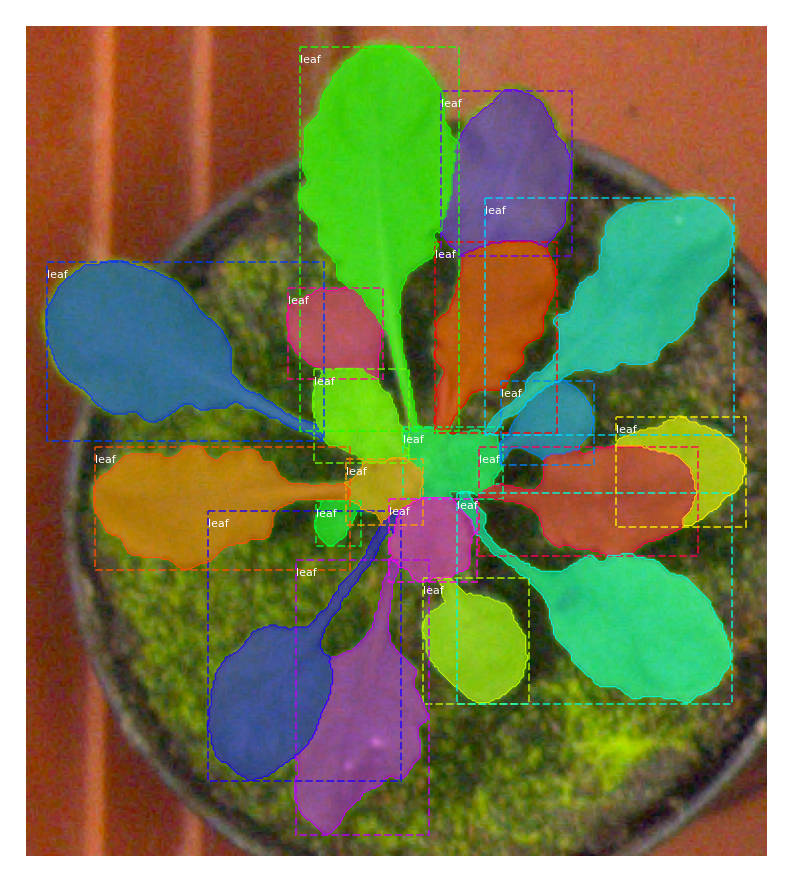

In [78]:
# Load random image and mask.
image_id = random.choice(train_set.image_ids)
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
# Compute Bounding box
print("test for annnnnnsoooooon", mask.shape)

print(mask)

bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, train_set.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#

In [79]:
# image_ids = np.random.choice(train_set.image_ids, 20)
# for image_id in image_ids:
#     print(image_id)
#     image = train_set.load_image(image_id)
#     mask, class_ids = train_set.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, train_set.class_names)


In [80]:
# # Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 4)
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


In [81]:
print("Loading Mask R-CNN model...")
print(os.getcwd())

model = modellib.MaskRCNN(mode="training", config=config, 
                          model_dir='./')


Loading Mask R-CNN model...
/content/Mask_RCNN
MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant066_label
PRINTING F  7fb6050783cc4a148d104c954b4d41bf.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant066_label/7fb6050783cc4a148d104c954b4d41bf.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(388, 390)
PRINTING F  0fc5df5860034600bbb175595f716251.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant066_label/0fc5df5860034600bbb175595f716251.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False Fals

In [82]:
#load the weights for COCO
model.load_weights('/content/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant088_label
PRINTING F  2b0f1f4d663b48a9b63df4cd65356204.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant088_label/2b0f1f4d663b48a9b63df4cd65356204.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(338, 380)
PRINTING F  903f168fc1214c1cbff4066cca58c51e.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant088_label/903f168fc1214c1cbff4066cca58c51e.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:

In [83]:
model.train(train_set, test_set, learning_rate=0.001, epochs=10, layers="heads")
history = model.keras_model.history.history


2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(369, 358)
PRINTING F  f3c20b3bacff423983f78647138f84d8.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant078_label/f3c20b3bacff423983f78647138f84d8.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(369, 358)
PRINTING F  0fd5103758e74716904a9308dc0d78ea.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant078_label/0fd5103758e74716904a9308dc0d78ea.png
2 seee@@@@ :  [[False False False ... False False False]
 [False

KeyboardInterrupt: ignored

MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant089_label
PRINTING F  dcddd017cdc24e02b8286e332d00a575.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant089_label/dcddd017cdc24e02b8286e332d00a575.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(281, 297)
PRINTING F  78935e0ed18f481d9ab2893b711606f5.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant089_label/78935e0ed18f481d9ab2893b711606f5.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:

In [85]:
model_path = '/content/Mask_RCNN/maskrcnn_config20220414T0046/mask_rcnn_maskrcnn_config_0002.h5'
model.keras_model.save_weights(model_path)




In [89]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)
img = load_img('/content/drive/MyDrive/Plant/Ara2012/ara2012_plant115_rgb.png')
img = img_to_array(img)
# detecting objects in the image
result= model.detect([img])
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")



Re-starting from epoch 2


NameError: ignored

MASK DIR  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant116_label
PRINTING F  c3279fa073554251b4147b756b73a925.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant116_label/c3279fa073554251b4147b756b73a925.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:
(428, 463)
PRINTING F  f050712d83964e40b33114d41c828479.png
location:  /content/drive/MyDrive/Plant/Ara2012/a2012/ara2012_plant116_label/f050712d83964e40b33114d41c828479.png
2 seee@@@@ :  [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
printing shape:

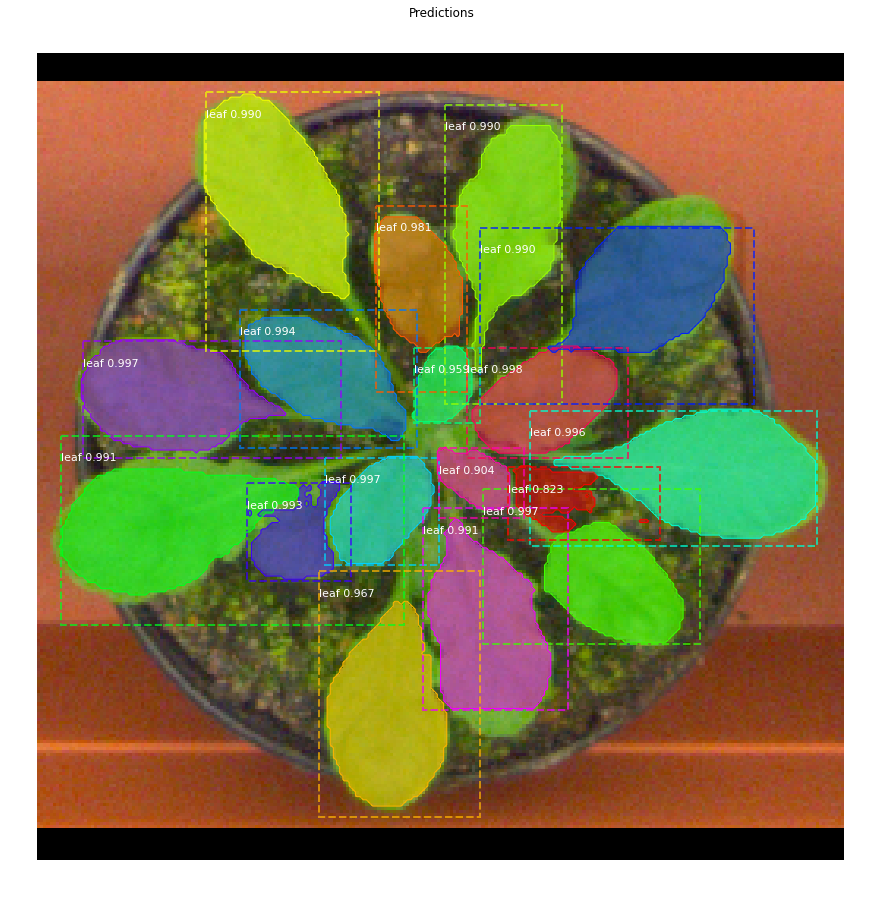

In [91]:
image_id = 5
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, config, image_id)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)
# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], 
                            title="Predictions")


In [ ]:
# # Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)
# # 
# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))


In [ ]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# # visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())
